# Model 1:

In [1]:

#! pip3 install auto-sklearn

In [2]:
import os
os.chdir('..')

In [3]:
import pandas as pd
import os
import numpy as np
RNDSEED = np.random.seed(39)
PRECISION = 4 # 3 of digits to keep after the decimal point
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import f1_score, cohen_kappa_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
RUNNING_ON_COLAB = False # we assume running on CoLab! Change to False if running locally.

*italicized text*

In [4]:
## mount gdrive
#from google.colab import drive#
#drive.mount("/content/gdrive")

In [6]:
# If running locally, define current working path
path = os.getcwd()

# If Google colab
if RUNNING_ON_COLAB:
    path = "/content/gdrive/My Drive/Colab Notebooks/RandomForest_FeatureData"

print(path)

# define current data path. This is after we did classification. We have done some
# cleaning already.
data_path = path + '/fl_testbed/version2/data/initial'
print(data_path)
#/home/jose/FL_AM_Defect-Detection
#/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial

/home/jose/FL_AM_Defect-Detection
/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial


## Play code

<font color=cyan>The key is to transform the time column! </font>


In [7]:
!cd '/home/jose/FL_AM_Defect-Detection/notebooks/fl_testbed/version2/data/initial' && ls

/bin/bash: line 0: cd: /home/jose/FL_AM_Defect-Detection/notebooks/fl_testbed/version2/data/initial: No such file or directory


In [8]:
## start - play code
print(data_path)
csv_file = data_path + '/grouped.combined_offset_misalignment.csv'
df_temp = pd.read_csv(csv_file, chunksize=50000) 
df = pd.concat(df_temp, ignore_index=True)

/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial


FileNotFoundError: [Errno 2] No such file or directory: '/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial/grouped.combined_offset_misalignment.csv'

In [8]:
print(df.columns)

Index(['Unnamed: 0', 'wf_start_time', 'S1_CrestFactor_g~g', 'S1_DerivedPeak_g',
       'S1_Peak~Peak_g', 'S1_RMS_g', 'S1_TruePeak_g', 'S1_HighFrequency_grms',
       'S1_Kurtosis_g~g', 'S2_CrestFactor_g~g', 'S2_DerivedPeak_g',
       'S2_Peak~Peak_g', 'S2_RMS_g', 'S2_TruePeak_g', 'S2_HighFrequency_grms',
       'S2_Kurtosis_g~g', 'S1_temp', 'status', 'rul'],
      dtype='object')


In [9]:
df.head(5)

,Unnamed: 0,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,0,2022-08-30 19:17:41.000007,2.9679,0.1485,0.6232,0.1050,0.3116,0.0303,2.3544,3.1791,0.4064,1.7640,0.2874,0.9136,0.2825,2.6123,72.5867,6.25mm_Offset,176049.0
1,1,2022-08-30 19:17:42.000007,3.0104,0.1511,0.6261,0.1069,0.3217,0.0310,2.3787,3.1860,0.4075,1.7210,0.2882,0.9180,0.2853,2.5937,72.5893,6.25mm_Offset,176048.0
2,2,2022-08-30 19:17:43.000007,3.2165,0.1611,0.6889,0.1139,0.3664,0.0309,2.3040,3.0295,0.4087,1.6775,0.2890,0.8755,0.2840,2.5947,72.5610,6.25mm_Offset,176047.0
3,3,2022-08-30 19:17:44.000007,3.1404,0.1388,0.6156,0.0981,0.3081,0.0309,2.4416,3.1823,0.4082,1.7048,0.2886,0.9185,0.2841,2.5852,72.5600,6.25mm_Offset,176046.0
4,4,2022-08-30 19:17:45.000007,3.4300,0.1520,0.6706,0.1075,0.3686,0.0302,2.3783,3.1616,0.4062,1.7570,0.2873,0.9082,0.2830,2.6230,72.5711,6.25mm_Offset,176045.0


In [10]:
#238722
#DO NOT FORGET SORT VALUES
df1=df.loc[0:238721].sort_values(by='wf_start_time').reset_index()
df2=df.loc[0+238722:0+238722+238722-1].sort_values(by='wf_start_time').reset_index()
df3=df.loc[0+238722+238722:].sort_values(by='wf_start_time').reset_index()

In [11]:
lists=[]
for df in [df1,df2,df3]:
    # Let's find the youngest & oldest timestamp

    df['wf_start_time'] = pd.to_datetime(df['wf_start_time']) # make sure it is datetime

    youngest = min(df.wf_start_time)
    oldest = max(df.wf_start_time)
    print(youngest)
    print(oldest)
    span = oldest - youngest
    print(span)
    print(span.total_seconds())

    ## Using Oldest - current to determine the RUL
    df['rul'] = df['wf_start_time'].apply(lambda x: (oldest - x).total_seconds())
    lists.append(df)


2022-08-09 14:03:22.000007
2022-09-01 20:11:50.000007
23 days 06:08:28
2009308.0
2022-08-09 14:03:22.000007
2022-09-01 20:11:50.000007
23 days 06:08:28
2009308.0
2022-08-09 14:03:22.000007
2022-09-01 20:11:50.000007
23 days 06:08:28
2009308.0


# ONLY ONE SET OF SIGNALS!

In [12]:
df=pd.concat(lists[-1:],ignore_index=True)

In [13]:
df.shape

(238722, 20)

In [14]:
# drop Unnamed columns
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]


# Most important features from the RF CLassif

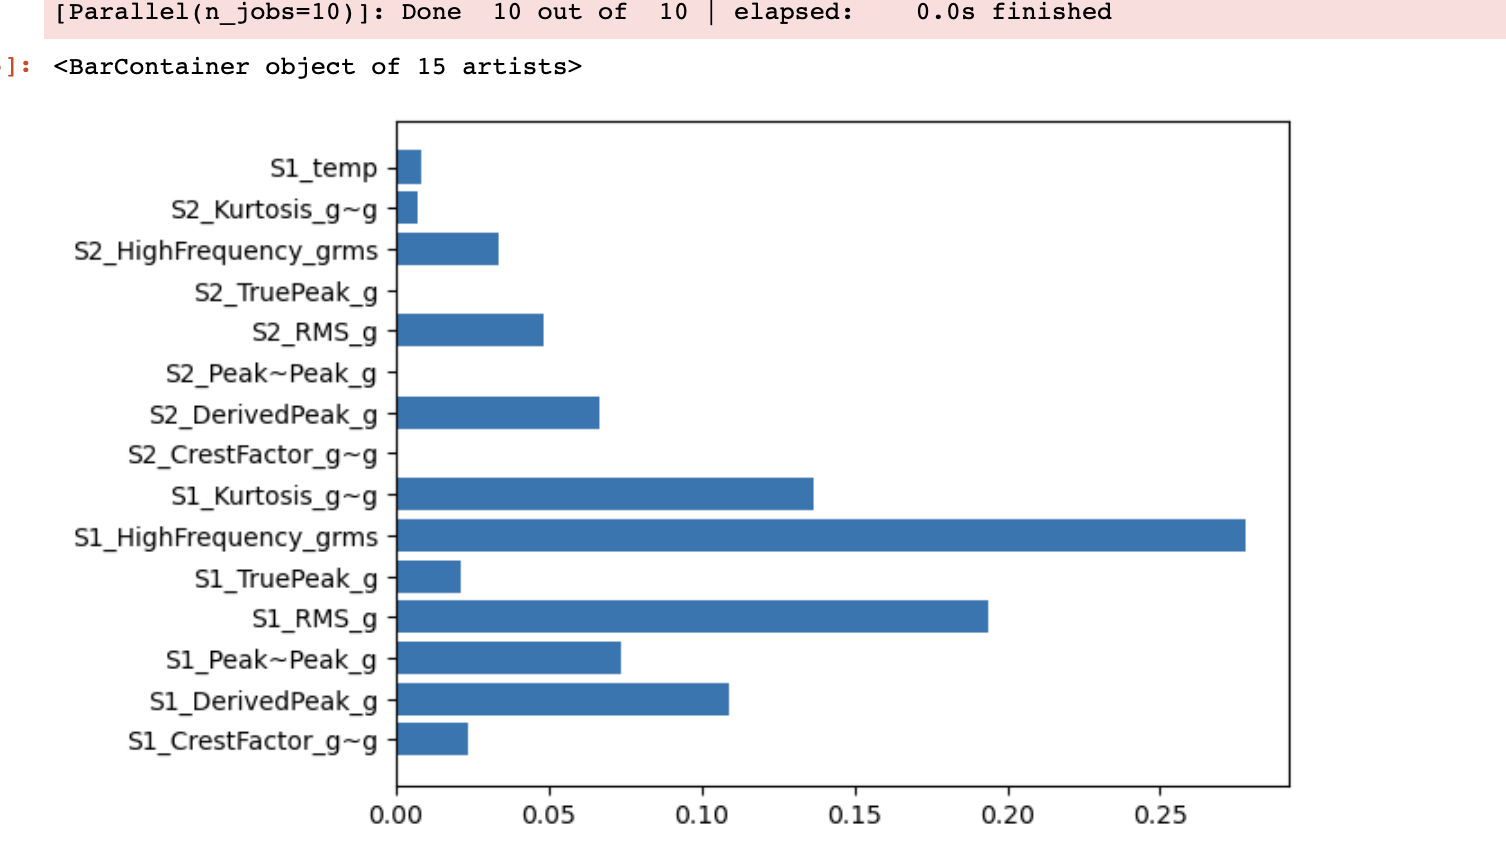

# SMALLER SET!

In [15]:
df=df[['index','wf_start_time','S1_HighFrequency_grms','S1_Kurtosis_g~g','S1_RMS_g','status','rul']]

In [16]:
df.loc[0:238721]


,index,wf_start_time,S1_HighFrequency_grms,S1_Kurtosis_g~g,S1_RMS_g,status,rul
0,591557,2022-08-09 14:03:22.000007,0.1355,29.4402,0.3655,No_Offset,2009308.0
1,591558,2022-08-09 14:03:23.000007,1.9368,8.9174,1.8019,No_Offset,2009307.0
2,591559,2022-08-09 14:03:24.000007,1.6188,5.0306,1.8020,No_Offset,2009306.0
3,591560,2022-08-09 14:03:25.000007,0.4809,2.2368,0.4910,No_Offset,2009305.0
4,591561,2022-08-09 14:03:26.000007,0.4748,2.2111,0.4774,No_Offset,2009304.0
...,...,...,...,...,...,...,...
238717,643079,2022-09-01 20:11:29.000007,0.4834,2.1624,0.4865,12.7mm_Offset,21.0
238718,643080,2022-09-01 20:11:30.000007,0.4837,2.1555,0.4864,12.7mm_Offset,20.0
238719,643081,2022-09-01 20:11:31.000007,0.0308,13.5090,0.1808,12.7mm_Offset,19.0
238720,643082,2022-09-01 20:11:32.000007,0.0115,3.1910,0.0287,12.7mm_Offset,18.0


In [17]:
df.loc[0+238722:0+238722+238722-1]


,index,wf_start_time,S1_HighFrequency_grms,S1_Kurtosis_g~g,S1_RMS_g,status,rul


In [18]:
df.loc[0+238722+238722:]

,index,wf_start_time,S1_HighFrequency_grms,S1_Kurtosis_g~g,S1_RMS_g,status,rul


In [19]:
# df.head(5)

In [20]:
df.columns

Index(['index', 'wf_start_time', 'S1_HighFrequency_grms', 'S1_Kurtosis_g~g',
       'S1_RMS_g', 'status', 'rul'],
      dtype='object')

In [21]:
# save back
#df.to_csv(csv_file)

## saved more than 50% space!

In [22]:
# csv_file

In [23]:
# os.path.basename(os.path.dirname(csv_file))

In [24]:
## end - play code

## Util - add RUL column

In [25]:
# csv_file = data_path + '/combined_offset_misalignment.csv'
# df_temp = pd.read_csv(csv_file, chunksize=50000) 
# df = pd.concat(df_temp, ignore_index=True)

In [26]:
# # Let's find the youngest & oldest timestamp

# df['wf_start_time'] = pd.to_datetime(df['wf_start_time']) # make sure it is datetime

# youngest = min(df.wf_start_time)
# oldest = max(df.wf_start_time)
# print(youngest)
# print(oldest)
# span = oldest - youngest
# print(span)
# print(span.total_seconds())

# ## Using Oldest - current to determine the RUL
# df['rul'] = df['wf_start_time'].apply(lambda x: (oldest - x).total_seconds())

In [27]:
# # save back with RUL
# df.to_csv(data_path + '/combined_offset_misalignment_with_RUL.csv')


In [28]:
# df.head()

In [29]:
df.loc[0:238721]


,index,wf_start_time,S1_HighFrequency_grms,S1_Kurtosis_g~g,S1_RMS_g,status,rul
0,591557,2022-08-09 14:03:22.000007,0.1355,29.4402,0.3655,No_Offset,2009308.0
1,591558,2022-08-09 14:03:23.000007,1.9368,8.9174,1.8019,No_Offset,2009307.0
2,591559,2022-08-09 14:03:24.000007,1.6188,5.0306,1.8020,No_Offset,2009306.0
3,591560,2022-08-09 14:03:25.000007,0.4809,2.2368,0.4910,No_Offset,2009305.0
4,591561,2022-08-09 14:03:26.000007,0.4748,2.2111,0.4774,No_Offset,2009304.0
...,...,...,...,...,...,...,...
238717,643079,2022-09-01 20:11:29.000007,0.4834,2.1624,0.4865,12.7mm_Offset,21.0
238718,643080,2022-09-01 20:11:30.000007,0.4837,2.1555,0.4864,12.7mm_Offset,20.0
238719,643081,2022-09-01 20:11:31.000007,0.0308,13.5090,0.1808,12.7mm_Offset,19.0
238720,643082,2022-09-01 20:11:32.000007,0.0115,3.1910,0.0287,12.7mm_Offset,18.0


In [30]:
df.loc[0+238722:0+238722+238722-1]


,index,wf_start_time,S1_HighFrequency_grms,S1_Kurtosis_g~g,S1_RMS_g,status,rul


In [31]:
df.loc[0+238722+238722:] #NOW THIS IS VALIDATION DATA

,index,wf_start_time,S1_HighFrequency_grms,S1_Kurtosis_g~g,S1_RMS_g,status,rul


## RF Regression

In [32]:
## Common imports
import pandas as pd
import numpy as np
import csv
import os

from sklearn import tree
from sklearn import metrics
from sklearn.metrics import f1_score, cohen_kappa_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error
# from pandas_ml import ConfusionMatrix

import matplotlib
import matplotlib.pyplot as plt
plt.style.available
%matplotlib inline

# to make this notebook's output stable across runs
RNDSEED = np.random.seed(39)

### Exploring the data a bit & prep the df

In [33]:
# ## future, let's read the file
# csv_file = data_path + '/combined_offset_misalignment_with_RUL.csv'
# df_temp = pd.read_csv(csv_file, chunksize=50000) 
# big_df = pd.concat(df_temp)

In [34]:
#df = big_df # reset 

# drop unwanted cols
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))] # drop Unnamed
df = df[df.columns.drop(list(df.filter(regex='wf_start_time')))] # drop time column
#df = df[df.columns.drop(list(df.filter(regex='status')))] # drop status column
df = df[df.columns.drop(list(df.filter(regex='index')))] # drop status column



# Map OFFSET TYPE OF ERROR

In [35]:
status_map = {
    "No_Offset": 0,
    "1mm_Offset": 1,
    "3mm_Offset": 2,
    "6.25mm_Offset": 3,
    "12.7mm_Offset": 4,
}

df["status"] = df["status"].map(status_map)

In [36]:
df.shape

(238722, 5)

In [37]:
df.columns

Index(['S1_HighFrequency_grms', 'S1_Kurtosis_g~g', 'S1_RMS_g', 'status',
       'rul'],
      dtype='object')

# Removing Outliers

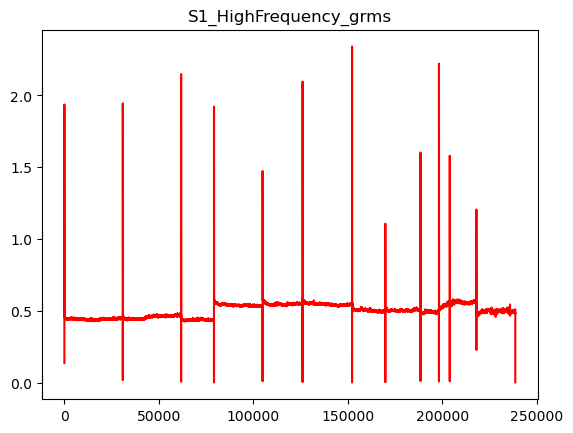

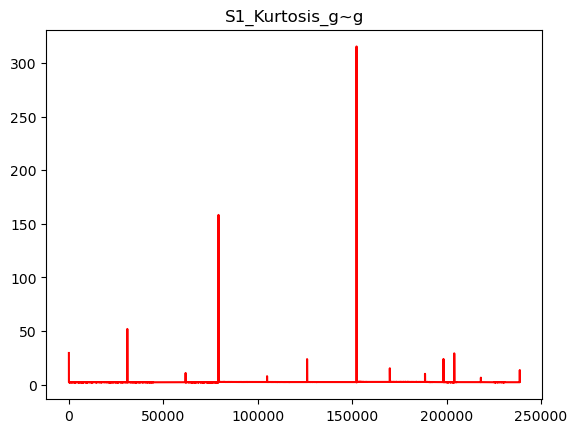

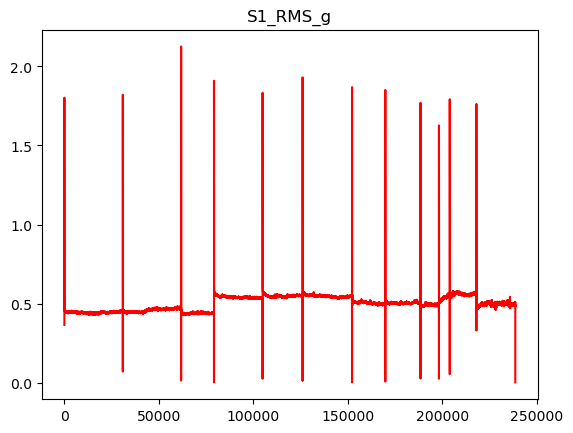

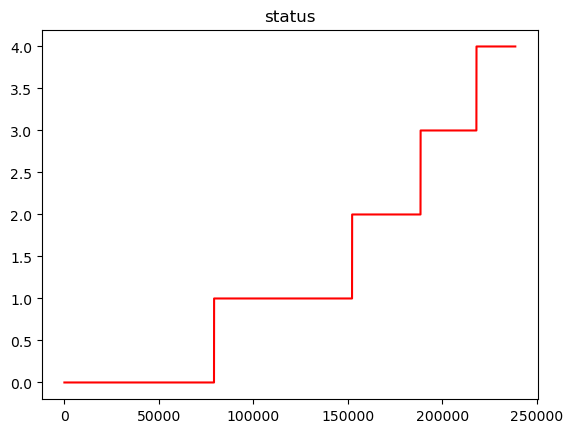

In [38]:

for i in df.columns[:-1]:
    
    y=df[[i]].values
    


    x = range(0,len(y))

    plt.title("Line graph")
    plt.plot(x, y, color="red")
    plt.title(str(i))

    plt.show()

In [39]:
from scipy import stats


cols = list(df.columns[:-3])

print(cols)


['S1_HighFrequency_grms', 'S1_Kurtosis_g~g']


# OUTLIERS REMOVAL

In [40]:

# df['S1_CrestFactor_g~g'] = df['S1_CrestFactor_g~g'].mask(np.abs(stats.zscore(df['S1_CrestFactor_g~g'])) >= 20)
# df['S1_DerivedPeak_g'] = df['S1_DerivedPeak_g'].mask(np.abs(stats.zscore(df['S1_DerivedPeak_g'])) >= 2)
# df['S1_Peak~Peak_g'] = df['S1_Peak~Peak_g'].mask(np.abs(stats.zscore(df['S1_Peak~Peak_g'])) >= 15)
df['S1_RMS_g'] = df['S1_RMS_g'].mask(np.abs(stats.zscore(df['S1_RMS_g'])) >= 1)
# df['S1_TruePeak_g'] = df['S1_TruePeak_g'].mask(np.abs(stats.zscore(df['S1_TruePeak_g'])) >= 4)
df['S1_HighFrequency_grms'] = df['S1_HighFrequency_grms'].mask(np.abs(stats.zscore(df['S1_HighFrequency_grms'])) >= 1.5)
df['S1_Kurtosis_g~g'] = df['S1_Kurtosis_g~g'].mask(np.abs(stats.zscore(df['S1_Kurtosis_g~g'])) >= 50)
# df['S2_CrestFactor_g~g'] = df['S2_CrestFactor_g~g'].mask(np.abs(stats.zscore(df['S2_CrestFactor_g~g'])) >= 8)
# df['S2_DerivedPeak_g'] = df['S2_DerivedPeak_g'].mask(np.abs(stats.zscore(df['S2_DerivedPeak_g'])) >= 1)
# df['S2_Peak~Peak_g'] = df['S2_Peak~Peak_g'].mask(np.abs(stats.zscore(df['S2_Peak~Peak_g'])) >= 6)
# df['S2_RMS_g'] = df['S2_RMS_g'].mask(np.abs(stats.zscore(df['S2_RMS_g'])) >= 0.6)
# df['S2_TruePeak_g'] = df['S2_TruePeak_g'].mask(np.abs(stats.zscore(df['S2_TruePeak_g'])) >= 3)
# df['S2_HighFrequency_grms'] = df['S2_HighFrequency_grms'].mask(np.abs(stats.zscore(df['S2_HighFrequency_grms'])) >= 0.50)
# df['S2_Kurtosis_g~g'] = df['S2_Kurtosis_g~g'].mask(np.abs(stats.zscore(df['S2_Kurtosis_g~g'])) >= 20)


# S1_HighFrequency_grms', 'S1_Kurtosis_g~g', 'S1_RMS_g'


In [41]:
df

,S1_HighFrequency_grms,S1_Kurtosis_g~g,S1_RMS_g,status,rul
0,NaN,29.4402,NaN,0,2009308.0
1,NaN,8.9174,NaN,0,2009307.0
2,NaN,5.0306,NaN,0,2009306.0
3,0.4809,2.2368,0.4910,0,2009305.0
4,0.4748,2.2111,0.4774,0,2009304.0
...,...,...,...,...,...
238717,0.4834,2.1624,0.4865,4,21.0
238718,0.4837,2.1555,0.4864,4,20.0
238719,NaN,13.5090,NaN,4,19.0
238720,NaN,3.1910,NaN,4,18.0


In [42]:
df = df.apply (pd.to_numeric, errors='coerce')
df = df.dropna()

In [43]:
df

,S1_HighFrequency_grms,S1_Kurtosis_g~g,S1_RMS_g,status,rul
3,0.4809,2.2368,0.4910,0,2009305.0
4,0.4748,2.2111,0.4774,0,2009304.0
5,0.4727,2.1923,0.4742,0,2009303.0
6,0.4733,2.1973,0.4744,0,2009302.0
7,0.4693,2.1964,0.4725,0,2009301.0
...,...,...,...,...,...
238714,0.4812,2.1637,0.4846,4,24.0
238715,0.4816,2.1602,0.4845,4,23.0
238716,0.4812,2.1647,0.4847,4,22.0
238717,0.4834,2.1624,0.4865,4,21.0


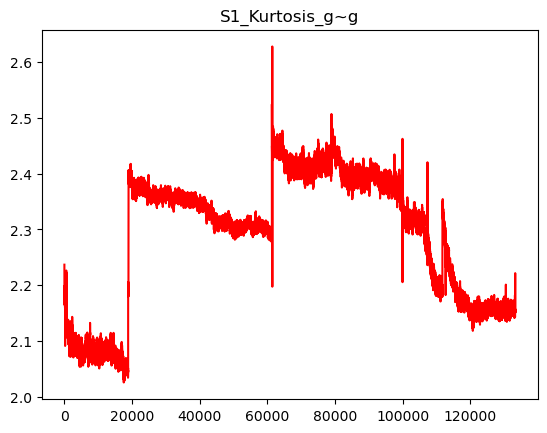

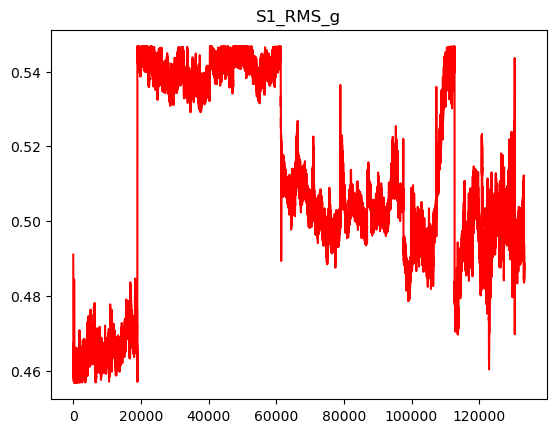

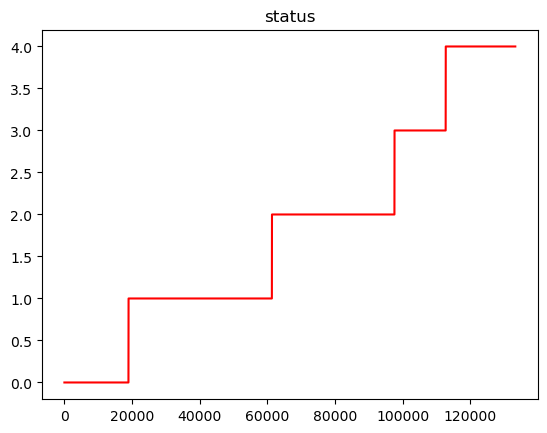

In [44]:

for i in df.columns[1:-1]:
    
    y=df[[i]].values
    


    x = range(0,len(y))

    plt.title("Line graph")
    plt.plot(x, y, color="red")
    plt.title(str(i))

    plt.show()

In [45]:
# Get X & y
# Naming convention: X as predictors; y as response.
from sklearn.model_selection import train_test_split

y = df[['status','rul']] # pop response




X = df.drop('rul',axis = 1) # drop response

print (X.shape)
print (X.columns)

(133304, 4)
Index(['S1_HighFrequency_grms', 'S1_Kurtosis_g~g', 'S1_RMS_g', 'status'], dtype='object')


In [46]:
## true orignal ones
# data split

# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = RNDSEED)

# Use the same function above for the validation set
X_train, X_vals, y_train, y_vals = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= RNDSEED,shuffle=False) # 0.25 x 0.8 = 0.2




In [47]:
y_test.shape

(26661, 2)

In [48]:
X_train.dtypes


S1_HighFrequency_grms    float64
S1_Kurtosis_g~g          float64
S1_RMS_g                 float64
status                     int64
dtype: object

In [49]:
df

,S1_HighFrequency_grms,S1_Kurtosis_g~g,S1_RMS_g,status,rul
3,0.4809,2.2368,0.4910,0,2009305.0
4,0.4748,2.2111,0.4774,0,2009304.0
5,0.4727,2.1923,0.4742,0,2009303.0
6,0.4733,2.1973,0.4744,0,2009302.0
7,0.4693,2.1964,0.4725,0,2009301.0
...,...,...,...,...,...
238714,0.4812,2.1637,0.4846,4,24.0
238715,0.4816,2.1602,0.4845,4,23.0
238716,0.4812,2.1647,0.4847,4,22.0
238717,0.4834,2.1624,0.4865,4,21.0


# Lets Take a Look to the data!

In [50]:
y_train=pd.DataFrame(y_train,columns = df.columns[-2:])
y_vals=pd.DataFrame(y_vals,columns = df.columns[-2:])
y_test=pd.DataFrame(y_test,columns = df.columns[-2:])

In [51]:
X_train

,S1_HighFrequency_grms,S1_Kurtosis_g~g,S1_RMS_g,status
3,0.4809,2.2368,0.4910,0
4,0.4748,2.2111,0.4774,0
5,0.4727,2.1923,0.4742,0
6,0.4733,2.1973,0.4744,0
7,0.4693,2.1964,0.4725,0
...,...,...,...,...
170939,0.5051,2.4340,0.5078,2
170940,0.5072,2.4320,0.5092,2
170941,0.5070,2.4385,0.5080,2
170942,0.5074,2.4365,0.5081,2


# LSTM

In [52]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Dropout,Conv1D,MaxPooling1D,Flatten, Activation, Dense
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.layers import Dropout,Conv1D,MaxPooling1D,Flatten, Activation
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from autosklearn.regression import AutoSklearnRegressor
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import L2,L1,L1L2

2023-06-09 16:35:00.916988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 16:35:01.584053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [53]:
X_train#.shape

,S1_HighFrequency_grms,S1_Kurtosis_g~g,S1_RMS_g,status
3,0.4809,2.2368,0.4910,0
4,0.4748,2.2111,0.4774,0
5,0.4727,2.1923,0.4742,0
6,0.4733,2.1973,0.4744,0
7,0.4693,2.1964,0.4725,0
...,...,...,...,...
170939,0.5051,2.4340,0.5078,2
170940,0.5072,2.4320,0.5092,2
170941,0.5070,2.4385,0.5080,2
170942,0.5074,2.4365,0.5081,2


In [54]:
# X_train.shape
# np.c_[m, v]


3         0.000000
4         0.000013
5         0.000025
6         0.000038
7         0.000050
            ...   
170939    0.999950
170940    0.999962
170941    0.999975
170942    0.999987
170943    1.000000
Name: rul, Length: 79982, dtype: float64
range(0, 79982)


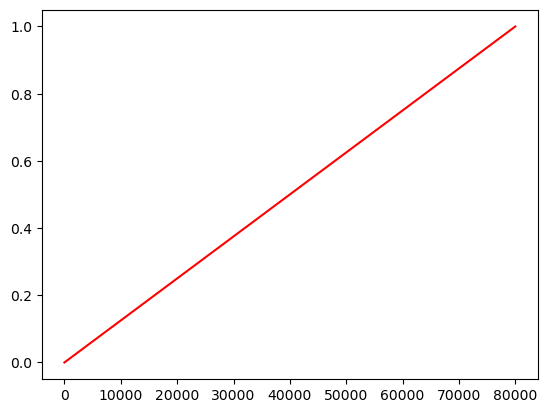

In [55]:
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt
import pandas as pd
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))



scaler=StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train),columns = df.columns[:-1])

# #STANDARIZING y
# min_max_scaler=MinMaxScaler()
# y_train=min_max_scaler.fit_transform(y_train)




model = np.poly1d(np.polyfit(range(0,len(y_train['rul'])), y_train['rul'], 1))
polyline = np.array(np.linspace(0,len(y_train['rul']),len(y_train['rul']) ) )

## Using Oldest - current to determine the RUL
y_train['rul'] = NormalizeData(polyline)
#ADDING A FILTER TO SMOOTHEN CURVE
plt.plot( range(0,len(y_train['rul'])),y_train['rul'] ,color='red')


print(y_train['rul'] )
print(range(0,len(y_train['rul'])))

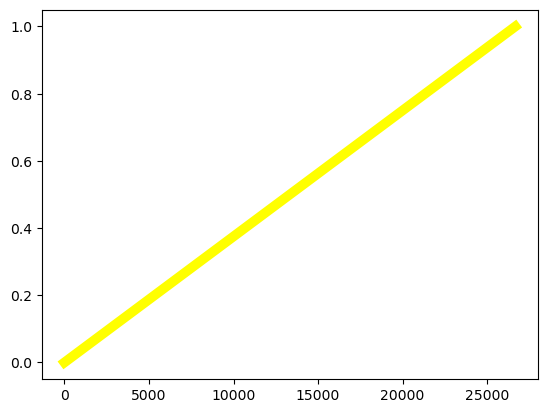

In [56]:


from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_vals=pd.DataFrame(scaler.fit_transform(X_vals), columns = df.columns[:-1])

# #STANDARIZING y
# min_max_scaler=MinMaxScaler()
# y_vals=min_max_scaler.fit_transform(y_vals)


model = np.poly1d(np.polyfit(range(0,len(y_vals['rul'])), y_vals['rul'], 1))
polyline = np.array(np.linspace(0,len(y_vals['rul']),len(y_vals['rul']) ) )

## Using Oldest - current to determine the RUL
y_vals['rul'] = NormalizeData(polyline)
#ADDING A FILTER TO SMOOTHEN CURVE
plt.plot(range(0,len(y_vals['rul'])),y_vals['rul'] , color='yellow',linewidth=7.0)




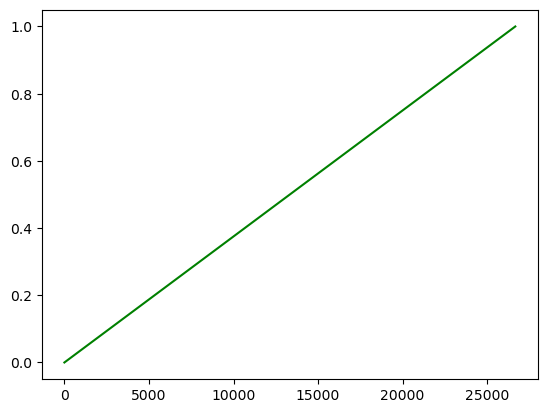

In [57]:



from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_test=pd.DataFrame(scaler.fit_transform(X_test), columns = df.columns[:-1])


# #STANDARIZING y
# min_max_scaler=MinMaxScaler()
# y_test=min_max_scaler.fit_transform(y_test)


model = np.poly1d(np.polyfit(range(0,len(y_test['rul'])), y_test['rul'], 1))
polyline = np.array(np.linspace(0,len(y_test['rul']),len(y_test['rul']) ) )

## Using Oldest - current to determine the RUL
y_test['rul'] = NormalizeData(polyline)
#ADDING A FILTER TO SMOOTHEN CURVE
plt.plot(range(0,len(y_test['rul'])),y_test['rul'] , color='green')




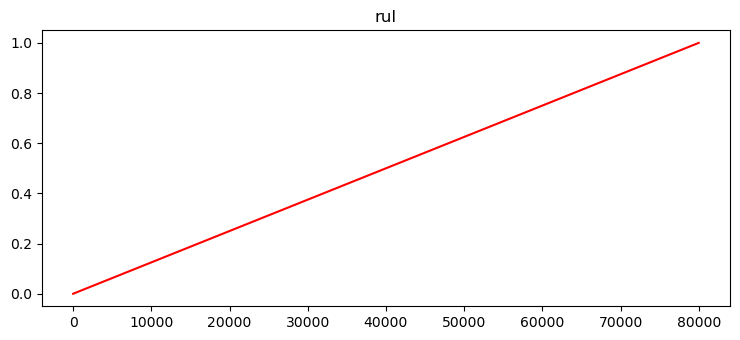

In [58]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("Line graph")
plt.title("rul")
plt.plot(range(0,len(y_train['rul'])),y_train['rul'], color="red")





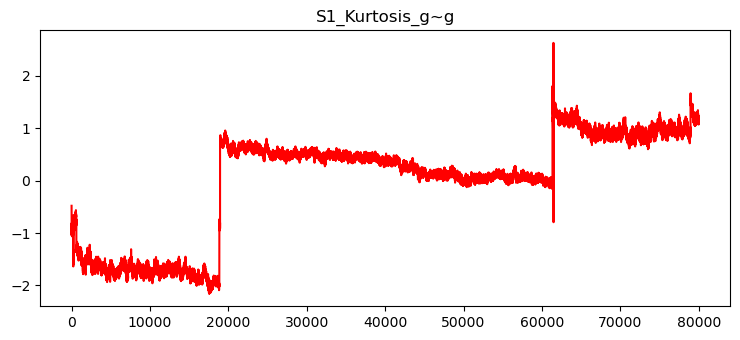

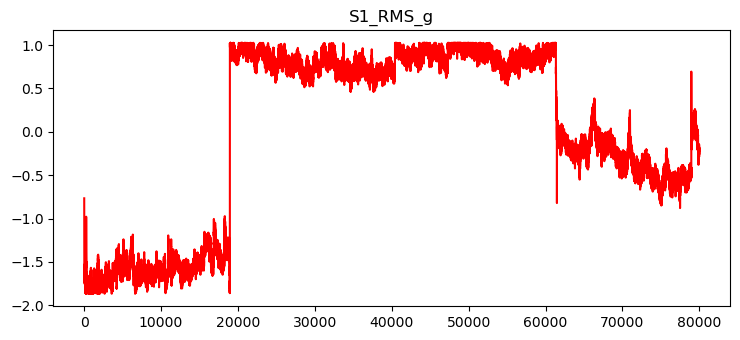

In [59]:

for i in X_train.columns[1:-1]:
    
    y=X_train[[i]].values
    


    x = range(0,len(y))

    plt.title("Line graph")
    plt.plot(x, y, color="red")
    plt.title(str(i))

    plt.show()

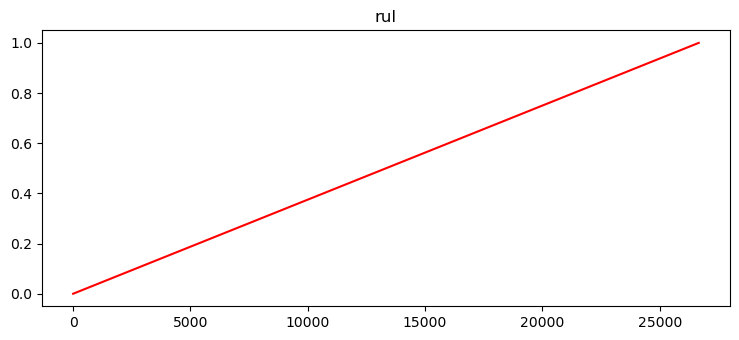

In [60]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("Line graph")
plt.title("rul")
plt.plot(range(0,len(y_test['rul'])),y_test['rul'], color="red")





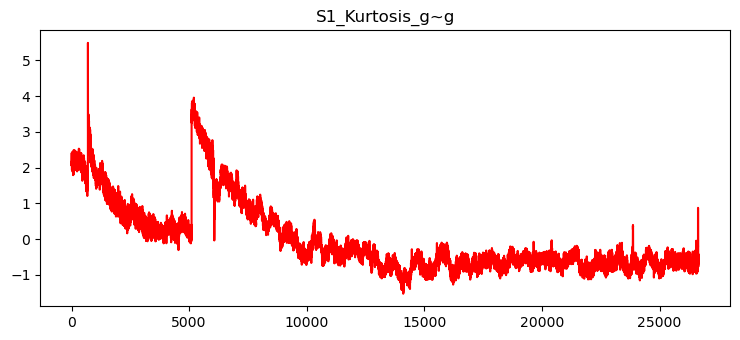

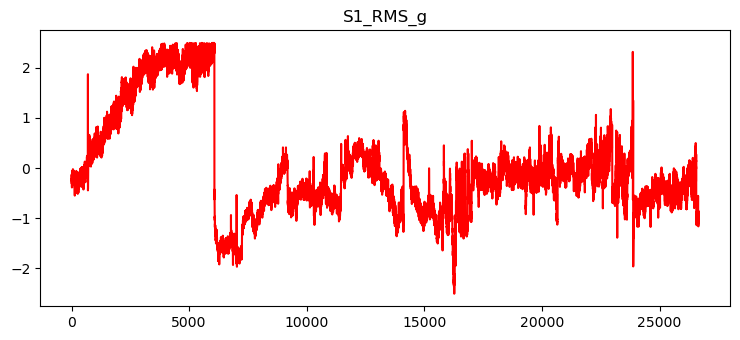

In [61]:



for i in X_test.columns[1:-1]:
    
    y=X_test[[i]].values
    


    x = range(0,len(y))

    plt.title("Line graph")
    plt.plot(x, y, color="red")
    plt.title(str(i))

    plt.show()



In [62]:
45*60

2700

In [63]:
seq_length=200
#STEPS_PER_BATCH=#X_vals.shape[0] IF 60 MINS OF DATA THEN 3600


###### LSTMs and Sequences:
LSTM models need 3 dimentional inputs (number of data rows, sequence_length, number of features). This because we need the LSTM to take a sequence of data (for example 60 mins of data) and from this sequence, we want the LSTM model to predict the RUL. These 3 inputs provide the LSTM model all the information about the tendancies and variations in the data for this period, which gives the LSTM model an idea about the state of the motor. This is a strength of LSTM models. They take a degradation period of the motor and determines how much the motor has degraded (percent of life left or RUL as a percent). 

For this RUL model we will take 60 minutes of data (sequence_length = 60). We can take more if we desire, but the more data we take the longer the computation time will be. The quality of the LSTM model's prediction will increase the more data (larger sequence_length) we take in, but the quality of prediction reaches a maximum limit to where it will not improve even if more data is taken in.

In [64]:
def gen_seq(data, seq_length, columns):
    L=[]
    n = data.shape[0]
    for i in range(0, n - seq_length):
        L.append(data[i:i+seq_length][columns].values)
    return(L)

###### Homogeneity of Sequences:
For LSTM models, the sequences should be homogeneous. To accomplish this, we generate the sequences depending on the category/day variable. We split each category to into sequences, and then join them into one array in the cells below (for train and test datasets).

(data, seq_length, columns):

data = train_data[train_data['category'] == id

seq_length = 60

columns = ["s1","s2","s3","s4","s5","s6","cycle"]

In [65]:
#INCLUSION OF STATUS

In [66]:
columns=df.columns[:-2]
columns

Index(['S1_HighFrequency_grms', 'S1_Kurtosis_g~g', 'S1_RMS_g'], dtype='object')

In [67]:
columns.shape

(3,)

In [68]:
target=df.columns[-1]
target

'rul'

In [69]:
X_train.shape

(79982, 4)

In [70]:
X_train

,S1_HighFrequency_grms,S1_Kurtosis_g~g,S1_RMS_g,status
0,-1.028852,-0.479235,-0.765886,-1.453457
1,-1.223379,-0.683627,-1.203291,-1.453457
2,-1.290348,-0.833143,-1.306210,-1.453457
3,-1.271214,-0.793378,-1.299778,-1.453457
4,-1.398772,-0.800536,-1.360886,-1.453457
...,...,...,...,...
79977,-0.257122,1.089090,-0.225561,1.464255
79978,-0.190154,1.073185,-0.180534,1.464255
79979,-0.196532,1.124879,-0.219129,1.464255
79980,-0.183776,1.108973,-0.215912,1.464255


In [71]:
seq_length
len(columns)
X_train['status'].unique()

array([-1.45345732,  0.00539898,  1.46425528])

In [72]:

train_inputs = np.concatenate(np.array([gen_seq(X_train[X_train['status'] == id], seq_length, columns)
                               for id in X_train['status'].unique()]))

/tmp/ipykernel_354400/3637815573.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_inputs = np.concatenate(np.array([gen_seq(X_train[X_train['status'] == id], seq_length, columns)


In [73]:
train_inputs.shape

(79382, 200, 3)

In [74]:
train_inputs

array([[[-1.02885224, -0.47923549, -0.7658856 ],
        [-1.22337921, -0.68362685, -1.20329122],
        [-1.29034751, -0.83314271, -1.3062102 ],
        ...,
        [-1.78782631, -0.84189098, -1.80472396],
        [-1.82290495, -0.8911994 , -1.8304537 ],
        [-1.80696012, -0.86177341, -1.79829152]],

       [[-1.22337921, -0.68362685, -1.20329122],
        [-1.29034751, -0.83314271, -1.3062102 ],
        [-1.27121371, -0.79337785, -1.29977776],
        ...,
        [-1.82290495, -0.8911994 , -1.8304537 ],
        [-1.80696012, -0.86177341, -1.79829152],
        [-1.81652702, -0.95243728, -1.82080505]],

       [[-1.29034751, -0.83314271, -1.3062102 ],
        [-1.27121371, -0.79337785, -1.29977776],
        [-1.39877238, -0.80053553, -1.3608859 ],
        ...,
        [-1.80696012, -0.86177341, -1.79829152],
        [-1.81652702, -0.95243728, -1.82080505],
        [-1.83247185, -0.95800436, -1.85939966]],

       ...,

       [[-0.07535119,  1.31018305, -0.09369608],
        [-0

In [75]:
30850/2643

11.672342035565645

In [76]:

test_inputs = np.concatenate(np.array([gen_seq(X_test[X_test['status'] == id], seq_length, columns)
                               for id in X_test['status'].unique()]))

/tmp/ipykernel_354400/3385912461.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_inputs = np.concatenate(np.array([gen_seq(X_test[X_test['status'] == id], seq_length, columns)


In [77]:
test_inputs.shape

(26261, 200, 3)

In [78]:

vals_inputs = np.concatenate(np.array([gen_seq(X_vals[X_vals['status'] == id], seq_length, columns)
                               for id in X_vals['status'].unique()]))

/tmp/ipykernel_354400/4079337520.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vals_inputs = np.concatenate(np.array([gen_seq(X_vals[X_vals['status'] == id], seq_length, columns)


In [79]:
vals_inputs.shape

(26261, 200, 3)

In [80]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]

In [81]:
train_out = np.concatenate(np.array([gen_labels(y_train[y_train['status'] == id], seq_length, [target])
                               for id in y_train['status'].unique()]))

/tmp/ipykernel_354400/3860507962.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_out = np.concatenate(np.array([gen_labels(y_train[y_train['status'] == id], seq_length, [target])


In [82]:
train_out.shape


(79382, 1)

In [83]:
test_out = np.concatenate(np.array([gen_labels(y_test[y_test['status'] == id], seq_length, [target])
                               for id in y_test['status'].unique()]))

/tmp/ipykernel_354400/2787026141.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_out = np.concatenate(np.array([gen_labels(y_test[y_test['status'] == id], seq_length, [target])


In [84]:
test_out.shape

(26261, 1)

In [85]:
vals_out = np.concatenate(np.array([gen_labels(y_vals[y_vals['status'] == id], seq_length, [target])
                               for id in y_vals['status'].unique()]))

/tmp/ipykernel_354400/1340672247.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vals_out = np.concatenate(np.array([gen_labels(y_vals[y_vals['status'] == id], seq_length, [target])


In [86]:
vals_out.shape

(26261, 1)

In [87]:
train_out

array([[0.00250059],
       [0.0025131 ],
       [0.0025256 ],
       ...,
       [0.99997499],
       [0.9999875 ],
       [1.        ]])

In [88]:

# !rm -rf logs/fit/*
# !rm -rf /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/*
from  datetime import datetime

In [89]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es=EarlyStopping(
    monitor="val_loss",

    patience=200,
    verbose=1,
    mode="auto",
    min_delta=0.0001
)

filepath=path+'/checkpoint/RUL16LSTM/'+"weights-improvement_BEST.h5"

# fname = os.path.sep.join([filepath,args["weights"],"weights-{epoch:03d}-{val_loss:.4f}.h5"])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_mae',

    mode='min',
    save_best_only=True, verbose=1)


# # checkpoint_filepath = "./tmp/checkpoint"

#scaler = MinMaxScaler()



logs/fit/20230609-163538


In [90]:
%load_ext tensorboard
%reload_ext tensorboard

# Scheduler

In [91]:

tf.keras.backend.clear_session()

nb_features = train_inputs.shape[2]
sequence_length  = train_inputs.shape[1]
nb_out = train_out.shape[1]

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape = (sequence_length, nb_features), return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(nb_out, activation = 'relu')
])

lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**-7 * 10**(epoch/3))

model.compile(loss=tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.Adam(lr = 10**-7), metrics =['mse','mae'])




2023-06-09 16:35:39.387528: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28330 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-06-09 16:35:40.138215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 16:35:40.139568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/sp

In [92]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 128)          67584     
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 199,297
Trainable params: 199,297
Non-trainable params: 0
_________________________________________________________________


In [93]:
#FAST AI SEE IF TRIANING IMPROVES !
# 1420492
# history = model.fit(train_inputs, train_out, epochs = 20, callbacks = [lr])
history=model.fit(train_inputs,train_out,epochs=100,validation_data= (vals_inputs,vals_out) ,verbose=1,callbacks=[tensorboard_callback,lr,model_checkpoint_callback,es],)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


Epoch 1/100


2023-06-09 15:49:56.780289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 15:49:56.781882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 15:49:56.783047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2480/2481 [============================>.] - ETA: 0s - loss: 0.1721 - mse: 0.3442 - mae: 0.5273

2023-06-09 15:50:40.163061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 15:50:40.166345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 15:50:40.167410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_mae improved from inf to 0.43075, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement_BEST.h5
2481/2481 [==============================] - 50s 18ms/step - loss: 0.1721 - mse: 0.3442 - mae: 0.5272 - val_loss: 0.1149 - val_mse: 0.2298 - val_mae: 0.4308 - lr: 1.0000e-07
Epoch 2/100
2478/2481 [============================>.] - ETA: 0s - loss: 0.1634 - mse: 0.3268 - mae: 0.4966
Epoch 2: val_mae did not improve from 0.43075
2481/2481 [==============================] - 43s 17ms/step - loss: 0.1634 - mse: 0.3268 - mae: 0.4966 - val_loss: 0.1362 - val_mse: 0.2724 - val_mae: 0.4558 - lr: 2.1544e-07
Epoch 3/100
2479/2481 [============================>.] - ETA: 0s - loss: 0.1242 - mse: 0.2484 - mae: 0.4377
Epoch 3: val_mae did not improve from 0.43075
2481/2481 [==============================] - 43s 17ms/step - loss: 0.1242 - mse: 0.2484 - mae: 0.4377 - val_loss: 0.1390 - val_mse: 0.2780 - val_mae: 0.4367 - lr: 4.6416e-07
Epoch 4/100
2481/2481 [

KeyboardInterrupt: 

# No Scheduler

In [93]:
from datetime import datetime
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es=EarlyStopping(
    monitor="val_loss",

    patience=200,
    verbose=1,
    mode="auto",
    min_delta=0.0001
)

filepath=path+'/checkpoint/RUL16LSTM/'+"weights-improvement_BEST.h5"

# fname = os.path.sep.join([filepath,args["weights"],"weights-{epoch:03d}-{val_loss:.4f}.h5"])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_mae',

    mode='min',
    save_best_only=True, verbose=1)


# # checkpoint_filepath = "./tmp/checkpoint"

#scaler = MinMaxScaler()



logs/fit/20230609-163540


In [ ]:
tf.keras.backend.clear_session()

nb_features = train_inputs.shape[2]
sequence_length  = train_inputs.shape[1]
nb_out = train_out.shape[1]

model = tf.keras.models.Sequential([
    # "1" 
    tf.keras.layers.LSTM(128, input_shape = (sequence_length, nb_features), return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.2),
    #"2"
    tf.keras.layers.Dense(nb_out, activation = 'relu')
])

model.compile(loss=tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.Adam(lr = 0.0014 ), metrics =['mse','mae'])
    # "3"          original lr 10**-7
# history = model.fit(train_inputs, train_out, epochs = 120)


### "use a validation_split of 10% of the training data"
history = model.fit(train_inputs, train_out, validation_data=(vals_inputs,vals_out), epochs = 150, verbose=1,callbacks=[tensorboard_callback,model_checkpoint_callback,es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

2023-06-09 16:35:40.558002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 16:35:40.559325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 16:35:40.560365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/150


2023-06-09 16:35:41.484205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 16:35:41.485709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 16:35:41.486799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2478/2481 [============================>.] - ETA: 0s - loss: 0.0045 - mse: 0.0091 - mae: 0.0705

2023-06-09 16:36:23.138423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-09 16:36:23.140014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-09 16:36:23.141051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_mae improved from inf to 0.49849, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement_BEST.h5
2481/2481 [==============================] - 48s 17ms/step - loss: 0.0045 - mse: 0.0091 - mae: 0.0705 - val_loss: 0.1721 - val_mse: 0.3442 - val_mae: 0.4985
Epoch 2/150
2479/2481 [============================>.] - ETA: 0s - loss: 0.0033 - mse: 0.0065 - mae: 0.0588
Epoch 2: val_mae did not improve from 0.49849
2481/2481 [==============================] - 43s 17ms/step - loss: 0.0033 - mse: 0.0065 - mae: 0.0588 - val_loss: 0.1807 - val_mse: 0.3614 - val_mae: 0.5136
Epoch 3/150
2481/2481 [==============================] - ETA: 0s - loss: 0.0032 - mse: 0.0064 - mae: 0.0575
Epoch 3: val_mae did not improve from 0.49849
2481/2481 [==============================] - 42s 17ms/step - loss: 0.0032 - mse: 0.0064 - mae: 0.0575 - val_loss: 0.1802 - val_mse: 0.3605 - val_mae: 0.5090
Epoch 4/150
2479/2481 [============================>.] - ETA: 0s - loss: 0

Epoch 26/150
2481/2481 [==============================] - ETA: 0s - loss: 4.4670e-04 - mse: 8.9340e-04 - mae: 0.0224
Epoch 26: val_mae did not improve from 0.36299
2481/2481 [==============================] - 43s 17ms/step - loss: 4.4670e-04 - mse: 8.9340e-04 - mae: 0.0224 - val_loss: 0.1503 - val_mse: 0.3006 - val_mae: 0.4722
Epoch 27/150
2480/2481 [============================>.] - ETA: 0s - loss: 4.1514e-04 - mse: 8.3028e-04 - mae: 0.0216
Epoch 27: val_mae did not improve from 0.36299
2481/2481 [==============================] - 43s 17ms/step - loss: 4.1507e-04 - mse: 8.3014e-04 - mae: 0.0216 - val_loss: 0.1546 - val_mse: 0.3093 - val_mae: 0.4825
Epoch 28/150
2478/2481 [============================>.] - ETA: 0s - loss: 3.8017e-04 - mse: 7.6033e-04 - mae: 0.0204
Epoch 28: val_mae did not improve from 0.36299
2481/2481 [==============================] - 43s 17ms/step - loss: 3.8010e-04 - mse: 7.6020e-04 - mae: 0.0204 - val_loss: 0.1618 - val_mse: 0.3237 - val_mae: 0.4917
Epoch 29/150


2478/2481 [============================>.] - ETA: 0s - loss: 5.4050e-04 - mse: 0.0011 - mae: 0.0243
Epoch 76: val_mae did not improve from 0.36299
2481/2481 [==============================] - 43s 17ms/step - loss: 5.4078e-04 - mse: 0.0011 - mae: 0.0243 - val_loss: 0.1336 - val_mse: 0.2673 - val_mae: 0.4474
Epoch 77/150
2479/2481 [============================>.] - ETA: 0s - loss: 7.0261e-04 - mse: 0.0014 - mae: 0.0275
Epoch 77: val_mae did not improve from 0.36299
2481/2481 [==============================] - 43s 17ms/step - loss: 7.0250e-04 - mse: 0.0014 - mae: 0.0275 - val_loss: 0.1457 - val_mse: 0.2915 - val_mae: 0.4669
Epoch 78/150
2480/2481 [============================>.] - ETA: 0s - loss: 5.8932e-04 - mse: 0.0012 - mae: 0.0252
Epoch 78: val_mae did not improve from 0.36299
2481/2481 [==============================] - 43s 17ms/step - loss: 5.8928e-04 - mse: 0.0012 - mae: 0.0252 - val_loss: 0.1525 - val_mse: 0.3050 - val_mae: 0.4819
Epoch 79/150
2480/2481 [==========================

# Brute Grid Model Search

Objective: + Low val_mae && + High Training Epochs 

In [ ]:
#OPTIMIZATION PARAMETERS

utc_time=[BEST_MODEL]# USE THE BEST RANDOM FOREST SAVED!!!!!!!! ADD IT AS A INTEGER
start_with_magicword = ['data/T18 50 percent radial immersion/']
FOLDS=[5] #KFOLD NUMBER OF FOLDS
THRESHOLD=[i for i in np.arange(0.05,0.15,0.05)] #[0.2,0.3,0.4,0.5,0.6,0.7,0.8] #FROM 0.1111 UP TO 0 0.9999
RATIO_THRESHOLD=[1.5,2,2.5] #HIGHER OR EQUAL THAN 1

In [ ]:
from typing import Iterable, Any
from itertools import product

def grid_parameters(parameters: dict[str, Iterable[Any]]) -> Iterable[dict[str, Any]]:
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))


parameters ={"FOLDS":FOLDS,"THRESHOLD":THRESHOLD,"RATIO_THRESHOLD":RATIO_THRESHOLD,"start_with_magicword":start_with_magicword,"utc_time":utc_time}
rfcs=[]
objectives=[]
for settings in grid_parameters(parameters):
    print(settings)
    # Some random fake model that needs learning_rate & penalty as arguments
    objective2,model2 = generalization_experiment(**settings)
    print("MODEL APPENDED")
    rfcs.append(model2)
    objectives.append(np.mean(objective2))
    print("NOTE RESUTLTS: ", np.mean(objective2))

In [ ]:

def optimizer():
    
    logger_dir = "logs/history/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    print(logger_dir)
    logger=tf.keras.callbacks.CSVLogger(logger_dir + ".csv", append=True)

    
    
    
    
    
    
    
    tf.keras.backend.clear_session()

    nb_features = train_inputs.shape[2]
    sequence_length  = train_inputs.shape[1]
    nb_out = train_out.shape[1]

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, input_shape = (sequence_length, nb_features), return_sequences = True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(nb_out, activation = 'relu')
    ])

    lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**-7 * 10**(epoch/3))

    model.compile(loss=tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.Adam(lr = 10**-7), metrics =['mse','mae'])
    
    history=model.fit(train_inputs,train_out,epochs=30,validation_data= (vals_inputs,vals_out) ,verbose=1,callbacks=[lr,model_checkpoint_callback,es,logger],)
    
    
    
    #OPTIMIZATION VARIABLES!
    
    best_val_mae = min(hist.history['val_mae'])
    best_val_mae = min(hist.history['val_loss'])
    
    
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model train vs validation loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper right')
#     plt.show()
    
    

    return 


# Models Summary

Original : Tenosorboard Log 135911

DropOut to 0.2->0.3:Tenosorboard Log 144836

Best: Tenosorboard Log151330

# Testing

In [121]:
# loading the saved modelweights-improvement-87-0.16.h /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement-07-0.04.h5
loaded_model = tf.keras.models.load_model('/home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement_BEST.h5')


2023-06-08 23:15:57.609502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 23:15:57.612207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 23:15:57.613267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [122]:
_test_inputs=test_inputs[0:]
_test_out=test_out[0:]



y_pred = loaded_model.predict(_test_inputs) ## using the untinted dataset!
    
print('R^2:', metrics.r2_score(_test_out, y_pred))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(_test_out, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(_test_out, y_pred))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(_test_out, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(_test_out, y_pred))) # np.sqrt

print('Explained Variance Score:', metrics.explained_variance_score(_test_out, y_pred))
print('Max Error:', metrics.max_error(_test_out, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(_test_out, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(_test_out, y_pred))

## with n_estimators = 150

# R^2: 0.9991654290573937
# Mean Absolute Error (MAE): 1158.6216816072117
# Mean Squared Error (MSE): 333818221.94037396
# Root Mean Squared Error (RMSE): 18270.692979205083
# Explained Variance Score: 0.9991654316522736
# Max Error: 1998236.0866666667
# Mean Squared Log Error: 0.012717975468372306
# Median Absolute Error: 147.4266666667536

## n_estimators = 10
# R^2: 0.9990822069686238
# Mean Absolute Error (MAE): 1213.5715068447246
# Mean Squared Error (MSE): 367106044.79767376
# Mean Absolute Percentage Error (MAPE): 1.0690696275079867e+17
# Root Mean Squared Error (RMSE): 19160.011607451437
# Explained Variance Score: 0.9990822141398445
# Max Error: 1998818.5
# Mean Squared Log Error: 0.012296657672986336
# Median Absolute Error: 137.60000000009313

2023-06-08 23:16:03.180151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-08 23:16:03.181623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-08 23:16:03.182696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

286/286 [==============================] - 14s 48ms/step
R^2: -4.796510810991104
Mean Absolute Error (MAE): 0.630037608837285
Mean Squared Error (MSE): 0.42280561975337067
Mean Absolute Percentage Error (MAPE): 1.4022730092772395
Root Mean Squared Error (RMSE): 0.650235049619267
Explained Variance Score: -4.615006349812001
Max Error: 0.9773719661893461
Mean Squared Log Error: 0.20083679257917228
Median Absolute Error: 0.6403730894535037


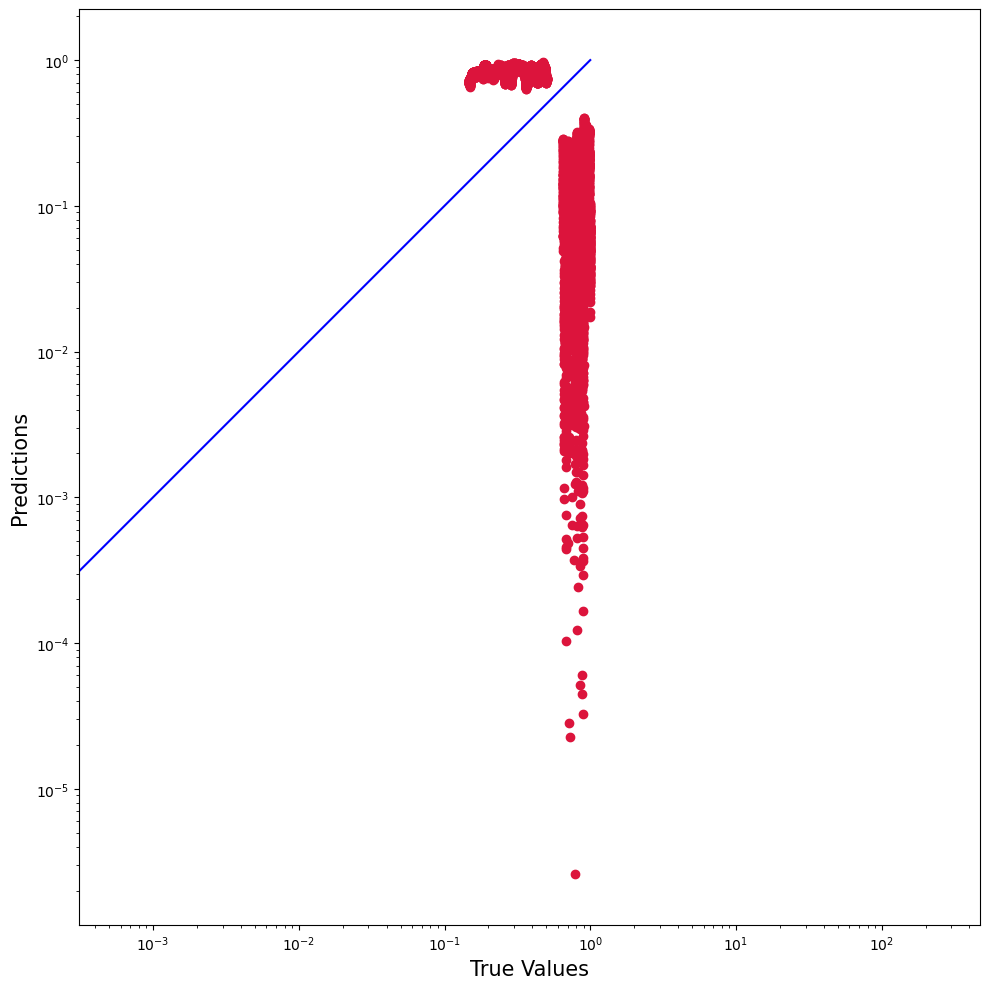

In [125]:
plt.figure(figsize=(10,10))
plt.scatter(_test_out, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(_test_out))
p2 = min(min(y_pred), min(_test_out))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# Model 2:


###### LSTMs and Sequences:
LSTM models need 3 dimentional inputs (number of data rows, sequence_length, number of features). This because we need the LSTM to take a sequence of data (for example 60 mins of data) and from this sequence, we want the LSTM model to predict the RUL. These 3 inputs provide the LSTM model all the information about the tendancies and variations in the data for this period, which gives the LSTM model an idea about the state of the motor. This is a strength of LSTM models. They take a degradation period of the motor and determines how much the motor has degraded (percent of life left or RUL as a percent). 

For this RUL model we will take 60 minutes of data (sequence_length = 60). We can take more if we desire, but the more data we take the longer the computation time will be. The quality of the LSTM model's prediction will increase the more data (larger sequence_length) we take in, but the quality of prediction reaches a maximum limit to where it will not improve even if more data is taken in.

In [1]:
train_data=pd.read_csv('/home/jose/FL_AM_Defect-Detection/DEC_DATA/train_data.csv',index_col=None)
test_data=pd.read_csv('/home/jose/FL_AM_Defect-Detection/DEC_DATA/test_data.csv',index_col=None)



NameError: name 'pd' is not defined

In [57]:
train_data.head()

,RUL,category,cycle,s1,s2,s3,s4,s5,s6
0,1.000000,1.0,0.000000,0.484999,0.486861,0.370133,0.664457,0.322148,0.372222
1,0.999971,1.0,0.000029,0.631700,0.478878,0.592081,0.589890,0.431123,0.446895
2,0.999943,1.0,0.000057,0.671811,0.494505,0.475300,0.609210,0.426485,0.453126
3,0.999914,1.0,0.000086,0.578963,0.416925,0.515753,0.357859,0.484526,0.483112
4,0.999885,1.0,0.000115,0.494712,0.543916,0.483542,0.220499,0.539660,0.484685


# Lets Take a Look to the data!

In [58]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'RUL')

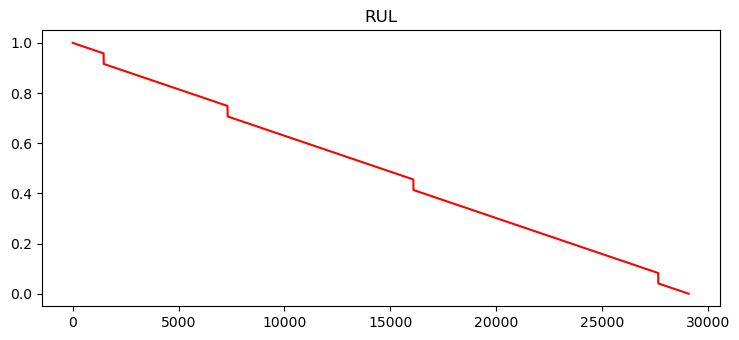

In [62]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("Line graph")
plt.plot(range(0,len(train_data['RUL'])),train_data['RUL'], color="red")
plt.title('RUL')


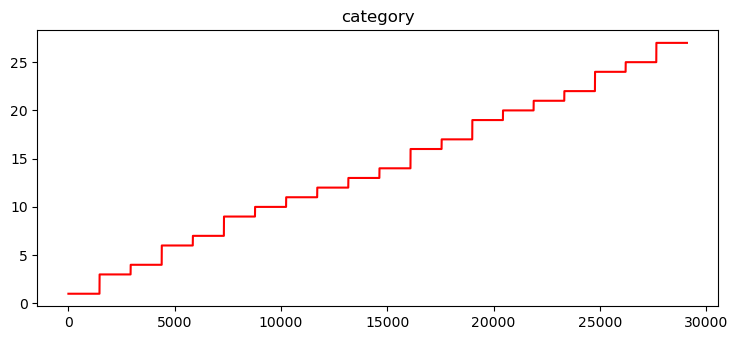

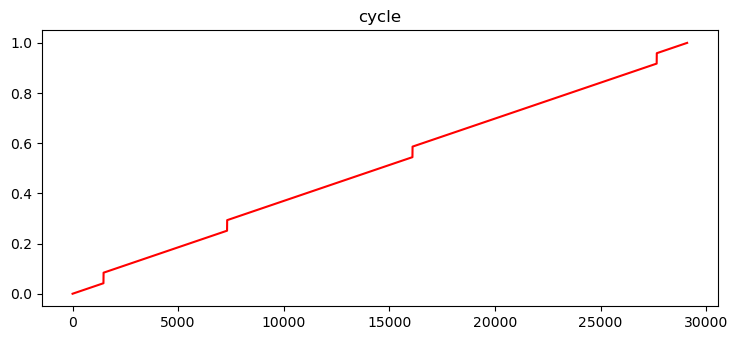

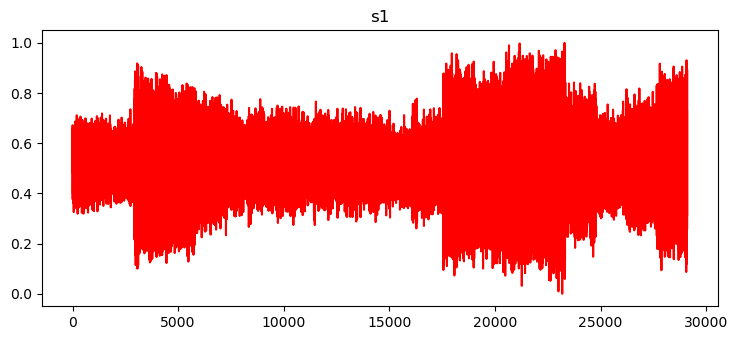

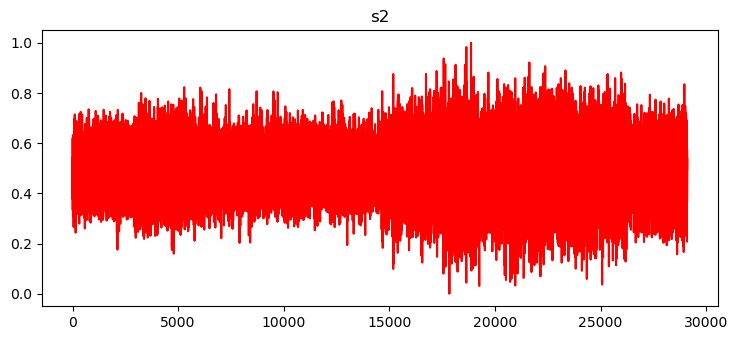

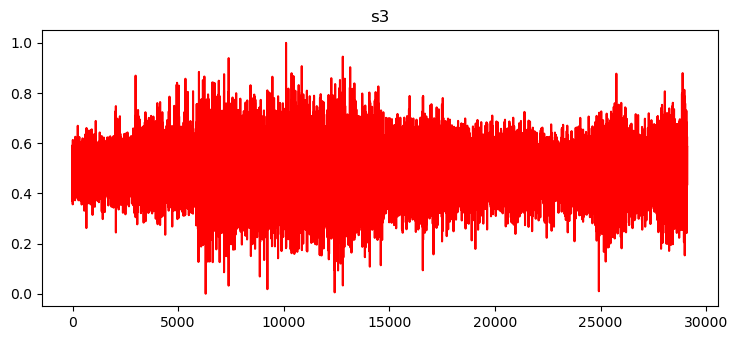

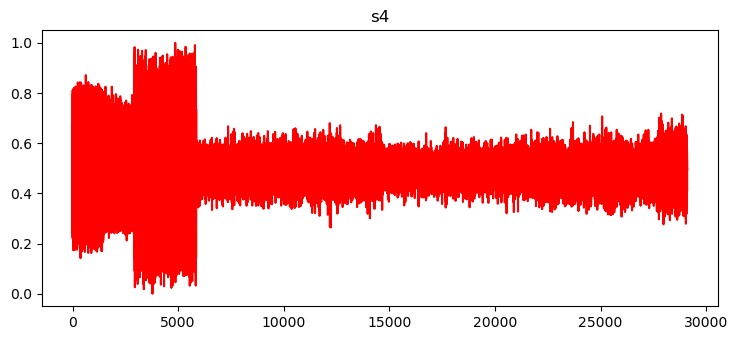

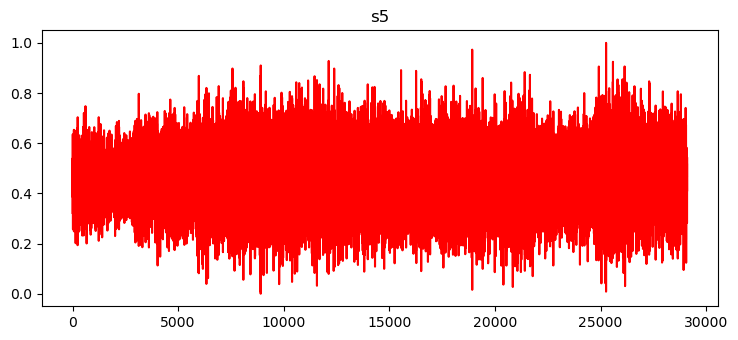

In [41]:
for i in train_data.columns[1:-1]:
    
    y=train_data[[i]].values
    


    x = range(0,len(y))

    plt.title("Line graph")
    plt.plot(x, y, color="red")
    plt.title(str(i))

    plt.show()

In [83]:
test_data.head()

,RUL,category,cycle,s1,s2,s3,s4,s5,s6
0,0.958117,2.0,0.041883,0.469170,0.499443,0.546157,0.474688,0.484226,0.501690
1,0.958089,2.0,0.041911,0.572775,0.385471,0.482286,0.226137,0.410976,0.300687
2,0.958060,2.0,0.041940,0.601086,0.360348,0.627149,0.323045,0.507235,0.498465
3,0.958032,2.0,0.041968,0.648032,0.383242,0.469450,0.627174,0.440170,0.491110
4,0.958003,2.0,0.041997,0.592633,0.576027,0.517164,0.735063,0.384482,0.480431


In [ ]:
def gen_seq(data, seq_length, columns):
    L=[]
    n = data.shape[0]
    for i in range(0, n - seq_length):
        L.append(data[i:i+seq_length][columns].values)
    return(L)


###### Homogeneity of Sequences:
For LSTM models, the sequences should be homogeneous. To accomplish this, we generate the sequences depending on the category/day variable. We split each category to into sequences, and then join them into one array in the cells below (for train and test datasets).

(data, seq_length, columns):

data = train_data[train_data['category'] == id

seq_length = 60

columns = ["s1","s2","s3","s4","s5","s6","cycle"]



In [84]:
# train_inputs = np.concatenate(np.array([gen_seq(train_data[train_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6","cycle"])
#                                for id in train_data['category'].unique()]))

train_inputs = np.concatenate(np.array([gen_seq(train_data[train_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6"])
                               for id in train_data['category'].unique()]))

train_inputs.shape


/tmp/ipykernel_341703/1987298931.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_inputs = np.concatenate(np.array([gen_seq(train_data[train_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6"])


(27900, 60, 6)

In [85]:
# train_out

# train_inputs

# for i in range(len(train_inputs)):
#     x = train_inputs[i]
#     print('%s => %s' % (x))

# test_inputs = np.concatenate(np.array([gen_seq(test_data[test_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6","cycle"])
#                                for id in test_data['category'].unique()]))

test_inputs = np.concatenate(np.array([gen_seq(test_data[test_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6"])
                               for id in test_data['category'].unique()]))

test_inputs.shape


/tmp/ipykernel_341703/940717228.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_inputs = np.concatenate(np.array([gen_seq(test_data[test_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6"])


(5592, 60, 6)

In [86]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]


In [87]:

train_out = np.concatenate(np.array([gen_labels(train_data[train_data['category'] == id], 60, ["RUL"])
                               for id in train_data['category'].unique()]))

train_out.shape

/tmp/ipykernel_341703/2284794544.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_out = np.concatenate(np.array([gen_labels(train_data[train_data['category'] == id], 60, ["RUL"])


(27900, 1)

In [88]:


test_out = np.concatenate(np.array([gen_labels(test_data[test_data['category'] == id], 60, ["RUL"])
                               for id in test_data['category'].unique()]))

test_out.shape

/tmp/ipykernel_341703/418674133.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_out = np.concatenate(np.array([gen_labels(test_data[test_data['category'] == id], 60, ["RUL"])


(5592, 1)

In [97]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def scheduler(epoch, lr):
      if epoch < 40:
        lr=0.00001
        return lr
      else:
        lr=0.0001
        return lr #* tf.math.exp(-0.1)
lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

es=EarlyStopping(
    monitor="val_loss",

    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.0001
)

filepath=path+'/checkpoint/RULDECLSTM/'+"weights-improvement-{epoch:02d}-{val_mae:.2f}.h5"

# fname = os.path.sep.join([filepath,args["weights"],"weights-{epoch:03d}-{val_loss:.4f}.h5"])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_mae',

    mode='min',
    save_best_only=True, verbose=1)


# # checkpoint_filepath = "./tmp/checkpoint"

#scaler = MinMaxScaler()



%load_ext tensorboard
%reload_ext tensorboard




# # Testing



# out_seq = np.array(y_test)#out_seq.reshape((len(out_seq), 1))
# # horizontally stack columns
# dataset = np.array(X_test)#hstack((in_seq1, in_seq2))

# pd.DataFrame(dataset)




# # shift the target sample by one step
# out_seq = np.insert(out_seq, 0, 0)
# #pre

# out_seq = np.delete(out_seq, -1)
# # define generator
# n_input = SEQUENCE_LENGHT #leght of the sequence timesteps
# testing_generator = TimeseriesGenerator(dataset, out_seq, length=n_input, batch_size=STEPS_PER_BATCH)
# # print each sample
# # for i in range(len(testing_generator)):
# #     x, y = generator[i]
# #     print('%s => %s' % (x, y))











tf.keras.backend.clear_session()

nb_features = train_inputs.shape[2]
sequence_length  = train_inputs.shape[1]
nb_out = train_out.shape[1]

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape = (sequence_length, nb_features), return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(nb_out, activation = 'relu')
])

lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**-7 * 10**(epoch/3))

model.compile(loss=tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.Adam(lr = 10**-7), metrics =['mse','mae'])

# # self.model
# model = Sequential()

# # hidden layers
# model.add(Dense(40, activation="relu", input_dim=X_train.shape[1],kernel_regularizer=L1L2(l2=0.01,l1=0.01))) #Better
# #GOOD 60

# model.add(Dropout(0.3))


# model.add(Dense(20, activation="relu",kernel_regularizer=L2(l2=0.001)))  #Better
# #GOOD 40
# model.add(Dropout(0.5))

# model.add(Dense(20, activation="linear"))

# # output layer
# model.add(Dense(1, activation="linear"))
# softmax for probability, #values are sigmoid


# Compile the network :
# NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
# NN_model.summary()

# Configure the model and start training
model.compile(loss='huber', optimizer='adam', metrics=['mae'])

model.summary()

# y_train
#50 and 30 -->
# R^2: 0.23383518186689745
# Mean Absolute Error (MAE): 396547.5620496487
# Mean Squared Error (MSE): 306771152615.1718
# Mean Absolute Percentage Error (MAPE): 3.5912102242185946e+17
# Root Mean Squared Error (RMSE): 553869.2558855129
# Explained Variance Score: 0.30378274542758565
# Max Error: 17869119.0
# Mean Squared Log Error: 2.760667782700153
# Median Absolute Error: 279682.8125






logs/fit/20230601-130857
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


2023-06-01 13:08:57.234611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:08:57.240234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:08:57.241397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            18176     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [98]:
#FAST AI SEE IF TRIANING IMPROVES !
# 1420492
# history = model.fit(train_inputs, train_out, epochs = 20, callbacks = [lr])
history=model.fit(train_inputs,train_out,epochs=30,validation_data= (test_inputs,test_out) ,verbose=1,callbacks=[tensorboard_callback,lr,model_checkpoint_callback,es],)


Epoch 1/30


2023-06-01 13:09:02.480312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:09:02.481865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:09:02.483092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

870/872 [============================>.] - ETA: 0s - loss: 0.1579 - mae: 0.4875

2023-06-01 13:09:11.964784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:09:11.966265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:09:11.967375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_mae improved from inf to 0.54123, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RULDECLSTM/weights-improvement-01-0.54.h5
872/872 [==============================] - 11s 9ms/step - loss: 0.1578 - mae: 0.4875 - val_loss: 0.2004 - val_mae: 0.5412 - lr: 1.0000e-07
Epoch 2/30
867/872 [============================>.] - ETA: 0s - loss: 0.1570 - mae: 0.4856
Epoch 2: val_mae did not improve from 0.54123
872/872 [==============================] - 6s 7ms/step - loss: 0.1570 - mae: 0.4856 - val_loss: 0.2004 - val_mae: 0.5412 - lr: 2.1544e-07
Epoch 3/30
865/872 [============================>.] - ETA: 0s - loss: 0.1526 - mae: 0.4766
Epoch 3: val_mae improved from 0.54123 to 0.54115, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RULDECLSTM/weights-improvement-03-0.54.h5
872/872 [==============================] - 6s 7ms/step - loss: 0.1525 - mae: 0.4764 - val_loss: 0.2004 - val_mae: 0.5411 - lr: 4.6416e-07
Epoch 4/30
871/872 [============================>.] 

In [102]:
### Saving model

model.summary()

# model.save(path+'MLP_REG_RUL_16',save_format='h5')



# loading the saved modelweights-improvement-87-0.16.h
loaded_model = tf.keras.models.load_model('/home/jose/FL_AM_Defect-Detection/checkpoint/RULDECLSTM/weights-improvement-16-0.08.h5')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            18176     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


2023-06-01 13:12:13.120451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:12:13.122616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:12:13.123690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [103]:
_test_inputs=test_inputs[0:]
_test_out=test_out[0:]



y_pred = loaded_model.predict(_test_inputs) ## using the untinted dataset!
    
print('R^2:', metrics.r2_score(_test_out, y_pred))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(_test_out, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(_test_out, y_pred))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(_test_out, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(_test_out, y_pred))) # np.sqrt

print('Explained Variance Score:', metrics.explained_variance_score(_test_out, y_pred))
print('Max Error:', metrics.max_error(_test_out, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(_test_out, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(_test_out, y_pred))

## with n_estimators = 150

# R^2: 0.9991654290573937
# Mean Absolute Error (MAE): 1158.6216816072117
# Mean Squared Error (MSE): 333818221.94037396
# Root Mean Squared Error (RMSE): 18270.692979205083
# Explained Variance Score: 0.9991654316522736
# Max Error: 1998236.0866666667
# Mean Squared Log Error: 0.012717975468372306
# Median Absolute Error: 147.4266666667536

## n_estimators = 10
# R^2: 0.9990822069686238
# Mean Absolute Error (MAE): 1213.5715068447246
# Mean Squared Error (MSE): 367106044.79767376
# Mean Absolute Percentage Error (MAPE): 1.0690696275079867e+17
# Root Mean Squared Error (RMSE): 19160.011607451437
# Explained Variance Score: 0.9990822141398445
# Max Error: 1998818.5
# Mean Squared Log Error: 0.012296657672986336
# Median Absolute Error: 137.60000000009313


2023-06-01 13:12:14.297030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:12:14.298515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:12:14.299597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

175/175 [==============================] - 1s 3ms/step
R^2: 0.9122389967444604
Mean Absolute Error (MAE): 0.08014411947907403
Mean Squared Error (MSE): 0.009466243663007943
Mean Absolute Percentage Error (MAPE): 0.5096658311603095
Root Mean Squared Error (RMSE): 0.09729462299124214
Explained Variance Score: 0.9162248820313804
Max Error: 0.35256587939942063
Mean Squared Log Error: 0.004816542903573396
Median Absolute Error: 0.06776273983800063


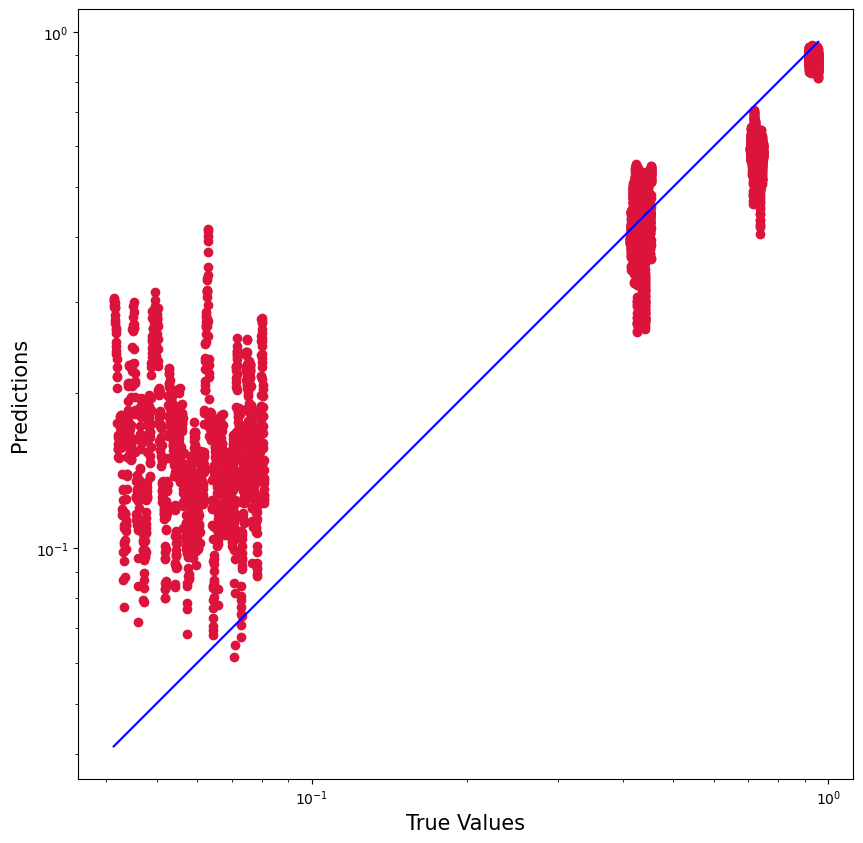

In [104]:

plt.figure(figsize=(10,10))
plt.scatter(_test_out, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(_test_out))
p2 = min(min(y_pred), min(_test_out))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()